# hcq_retinophaty_prediction

## Import libraries and read data

In [1]:
!pip install imblearn scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 53.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.9/297.9 kB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.5/380.5 kB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import cumulative_dynamic_auc
from sklearn.feature_selection import RFECV, SequentialFeatureSelector, SelectKBest,f_classif
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score
import imblearn
from imblearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/ferdmartin/hcq_retinophaty_prediction/main/dummydata_rsf_7_20_22.csv')

## Exploring dataset

In [4]:
df.head()

,id,age,weight_kg,height_inch,eGFR,astmean,cumulative_dose,female,diabetes,tamoxifen,retinaltoxin,highdose,race,hcqindication,bmi,outcome,fup_time,dosewt
0,1,50,67.7,63,76.1,18.3,357.0,1,0,0,0,1,White,lupus,26.438702,0,120,6.257509
1,2,59,80.8,65,89.1,23.3,564.0,1,0,0,0,0,White,Other/Unknown,29.642663,0,41,4.855915
2,3,56,76.5,65,84.8,21.5,520.0,1,0,0,0,1,White,lupus,28.065145,0,6,6.342299
3,4,70,96.5,68,104.5,31.1,240.0,1,0,0,0,0,White,RA,32.347599,0,44,2.039484
4,5,59,80.5,65,88.8,23.2,568.0,1,0,0,0,1,White,Sjogrens syndrome,29.532603,1,12,5.070541


In [5]:
df.outcome.value_counts()
# Imbalanced

0    4032
1     119
Name: outcome, dtype: int64

In [6]:
df.isna().sum()
# No nulls

id                 0
age                0
weight_kg          0
height_inch        0
eGFR               0
astmean            0
cumulative_dose    0
female             0
diabetes           0
tamoxifen          0
retinaltoxin       0
highdose           0
race               0
hcqindication      0
bmi                0
outcome            0
fup_time           0
dosewt             0
dtype: int64

In [7]:
df.describe()

,id,age,weight_kg,height_inch,eGFR,astmean,cumulative_dose,female,diabetes,tamoxifen,retinaltoxin,highdose,bmi,outcome,fup_time,dosewt
count,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000
mean,2076.000000,57.082390,79.198699,64.804384,85.953361,23.880029,490.597360,0.825584,0.065285,0.003614,0.011082,0.387377,28.773014,0.028668,67.933510,4.503707
std,1198.434813,13.563593,19.655275,3.617600,19.978272,9.482674,170.307368,0.379512,0.247059,0.060012,0.104697,0.487210,4.689372,0.166891,39.117154,1.974297
min,1.000000,22.000000,35.400000,53.000000,18.600000,6.300000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.633505,0.000000,1.000000,0.068902
25%,1038.500000,48.000000,65.100000,62.000000,72.400000,17.200000,362.000000,1.000000,0.000000,0.000000,0.000000,0.000000,25.806503,0.000000,33.000000,3.021613
50%,2076.000000,57.000000,78.700000,65.000000,86.200000,22.200000,508.000000,1.000000,0.000000,0.000000,0.000000,0.000000,28.982306,0.000000,64.000000,4.357873
75%,3113.500000,66.000000,92.300000,67.000000,99.800000,28.600000,644.000000,1.000000,0.000000,0.000000,0.000000,1.000000,31.744224,0.000000,110.000000,5.869446
max,4151.000000,94.000000,146.500000,77.000000,136.400000,77.900000,720.000000,1.000000,1.000000,1.000000,1.000000,1.000000,66.178116,1.000000,120.000000,12.236907


## Preparing our dataset for modelling

In [8]:
X, y = df.drop(['outcome', 'fup_time'], axis=1), list(df[['outcome', 'fup_time']].itertuples(index=False, name=None))
y = np.array(y, dtype=[('Status', '?'), ('time', '<f8')])
y_fs = df['outcome']

In [9]:
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=random_state)
X_train, X_test, y_train_fs, y_test_fs = train_test_split(X, y_fs, test_size=.20, random_state=random_state)

In [10]:
# Oversampling applied to dataset
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler()
X_train_res,  y_train_res = oversampler.fit_resample(X_train, y_train_fs)

X_train_oversampled = pd.DataFrame(columns=X_train.columns)
y_train_oversampled = None
sample_indices =  np.transpose(np.unique(oversampler.sample_indices_, return_counts=True))

index_destiny = 0
for index, times in sample_indices:
    for over_samp_iteration in range(times):
        X_train_oversampled.loc[index_destiny] = X_train_res.iloc[index]
        if y_train_oversampled is None:
            y_train_oversampled = y_train[0]
        else:
            y_train_oversampled = np.append(y_train_oversampled, y_train[index])
        index_destiny += 1

In [11]:
ohe = OneHotEncoder()
cat_cols = X_train.select_dtypes(include='object').columns
num_columns = X_train.drop(cat_cols, axis=1).columns.tolist()

X_train = pd.concat([pd.DataFrame(ohe.fit_transform(X_train[cat_cols]).toarray()), 
                     X_train.drop(cat_cols, axis=1).reset_index(drop=True)], axis=1)

X_train_oversampled = pd.concat([pd.DataFrame(ohe.transform(X_train_oversampled[cat_cols]).toarray()), 
                                 X_train_oversampled.drop(cat_cols, axis=1).reset_index(drop=True)], axis=1)

X_test = pd.concat([pd.DataFrame(ohe.transform(X_test[cat_cols]).toarray()), 
                     X_test.drop(cat_cols, axis=1).reset_index(drop=True)], axis=1)

cat_cols = ohe.get_feature_names_out().tolist()
cols = num_columns + cat_cols
X_train.columns = cols
X_train_oversampled.columns = cols
X_test.columns = cols

X_train = X_train.drop('id', axis=1); X_test = X_test.drop('id', axis=1); X_train_oversampled = X_train_oversampled.drop('id', axis=1)

In [12]:
std_scaler = StandardScaler()
X_train = pd.DataFrame(std_scaler.fit_transform(X_train), columns=X_train.columns)
X_train_oversampled = pd.DataFrame(std_scaler.transform(X_train_oversampled), columns=X_train_oversampled.columns)
X_test = pd.DataFrame(std_scaler.transform(X_test), columns=X_test.columns)

In [13]:
# Random Forest Classifier
RF = RandomForestClassifier(n_jobs=-1)
# Random Survival Forest
RSF = RandomSurvivalForest(n_jobs=-1)
# Cross Validation strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

## Feature Selection

In [14]:
# Feature selection not oversampled
## Forward
fs_Forward = SequentialFeatureSelector(estimator=RF, cv=cv, scoring='f1', direction='forward', n_features_to_select='auto')
fs_Forward.fit(X_train, y_train_fs)
## Backward
fs_Backward = SequentialFeatureSelector(estimator=RF, cv=cv, scoring='f1', direction='backward', n_features_to_select='auto')
fs_Backward.fit(X_train, y_train_fs)
## Wrapper
fs_Wrapper = RFECV(estimator=RF, cv=cv, scoring='f1', min_features_to_select=1)
fs_Wrapper.fit(X_train, y_train_fs)
# ANOVA
fs_anova = SelectKBest(score_func=f_classif, k=X_train.shape[1]//2)
fs_anova.fit(X_train, y_train_fs);

# Feature selection oversampled
fs_Forward_os = SequentialFeatureSelector(estimator=RF, cv=cv, scoring='f1', direction='forward', n_features_to_select='auto')
fs_Forward_os.fit(X_train_oversampled, y_train_res)
## Backward
fs_Backward_os = SequentialFeatureSelector(estimator=RF, cv=cv, scoring='f1', direction='backward', n_features_to_select='auto')
fs_Backward_os.fit(X_train_oversampled, y_train_res)
## Wrapper
fs_Wrapper_os = RFECV(estimator=RF, cv=cv, scoring='f1', min_features_to_select=1)
fs_Wrapper_os.fit(X_train_oversampled, y_train_res)
# ANOVA
fs_anova_os = SelectKBest(score_func=f_classif, k=X_train.shape[1]//2)
fs_anova_os.fit(X_train_oversampled, y_train_res);

### Best Feature Selection Method

In [15]:
# Select best feature selection method
fs_methods = [fs_Forward, fs_Backward, fs_Wrapper, fs_anova]
fs_score = 0
fs_columns = X_train.columns
best_fs_method = None
for fs_method in fs_methods:
    if fs_method is None:
        cvs = cross_val_score(estimator=RF, X=X_train, y=y_train_fs, scoring='f1', cv=cv)
        cvs_score = np.mean(cvs)
    else:
        cvs = cross_val_score(estimator=RF, X=X_train[fs_method.get_feature_names_out()], 
                              y=y_train_fs, scoring='f1', cv=cv)
        cvs_score = np.mean(cvs)
        
    if cvs_score > fs_score:
        fs_score = cvs_score
        best_fs_method = fs_method
        fs_columns = fs_method.get_feature_names_out()
        
# Select best feature selection method
fs_methods_os = [fs_Forward_os, fs_Backward_os, fs_Wrapper_os, fs_anova_os]
fs_score_os = 0
fs_columns_os = X_train_oversampled.columns
best_fs_method_os = None
for fs_method in fs_methods_os:
    if fs_method is None:
        cvs = cross_val_score(estimator=RF, X=X_train_oversampled, y=y_train_res, scoring='f1', cv=cv)
        cvs_score = np.mean(cvs)
    else:
        cvs = cross_val_score(estimator=RF, X=X_train_oversampled[fs_method.get_feature_names_out()], 
                              y=y_train_res, scoring='f1', cv=cv)
        cvs_score = np.mean(cvs)
        
    if cvs_score > fs_score:
        fs_score_os = cvs_score
        best_fs_method_os = fs_method
        fs_columns_os = fs_method.get_feature_names_out()

## RSF Experiments

In [16]:
# Cross Validation No Oversampling
cv_RSF = np.mean(cross_val_score(estimator=RSF, X=X_train[fs_columns].values, 
                              y=y_train, cv=cv))
# Cross Validation Oversampling
cv_RSF_os = np.mean(cross_val_score(estimator=RSF, X=X_train_oversampled[fs_columns_os].values, 
                              y=y_train_oversampled, cv=cv))

if cv_RSF > cv_RSF_os:
    RSF.fit(X_train[fs_columns].values, y_train)
    print('Best Performance: No Oversampling')
else:
    RSF.fit(X_train_oversampled[fs_columns_os].values, y_train_oversampled)
    X_train = X_train_oversampled
    fs_columns = fs_columns_os
    y_train = y_train_oversampled
    print('Best Performance: Oversampling')

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Performance: Oversampling


In [17]:
if cv_RSF > cv_RSF_os:
    RSF.fit(X_train[fs_columns].values, y_train)
    print('Best Performance: No Oversampling')
else:
    RSF.fit(X_train_oversampled[fs_columns_os].values, y_train_oversampled)
    X_train = X_train_oversampled
    fs_columns = fs_columns_os
    y_train = y_train_oversampled
    print('Best Performance: Oversampling')

Best Performance: Oversampling


In [18]:
print(cv_RSF)
print(cv_RSF_os)

0.5002256985214725
0.9666845116075639


In [19]:
## Get survival probability over time
RSF_surv_func = RSF.predict_survival_function(X_test[fs_columns].values, return_array=True)
## Predicting risk scores
RSF_risk_score = RSF.predict(X_test[fs_columns].values)

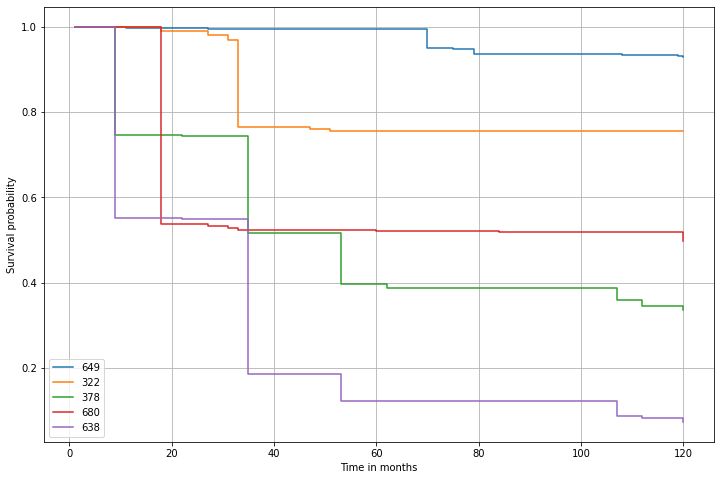

In [20]:
# Sample 5 spread entries
scores_cuts = pd.DataFrame({'score':RSF_risk_score, 'cut':pd.cut(RSF_risk_score, 5)})
scores_cuts['cut'].replace(np.sort(scores_cuts.cut.unique()),range(len(scores_cuts.cut.unique())), inplace=True)
ID_to_sample = []
for unique_cuts in scores_cuts['cut'].unique():
    ID_to_sample.append(scores_cuts[scores_cuts['cut'] == unique_cuts].sample().index)

sample = np.squeeze(np.take(RSF_surv_func, ID_to_sample, axis=0))
sample = tuple(zip([idx[0] for idx in np.int16(ID_to_sample)], sample))
# Plot the sample
plt.figure(figsize=(12,8))
for i, s in sample:
    plt.step(RSF.event_times_, s, where="post", label=str(i))

plt.ylabel("Survival probability")
plt.xlabel("Time in months")
plt.legend()
plt.grid(True)

In [43]:
# FOR AUC SCORE
def Survival_AUC_Score(survival_y_train, survival_x_test, survival_y_test, model, estimate, times):
    mins = []
    maxs = []
    times = np.percentile(times, np.linspace(0, 95, 30))
    for split in [survival_y_train, survival_y_test]:
      mins.append(min(split, key = lambda t: t[1])[1])
      maxs.append(max(split, key = lambda t: t[1])[1])
    if mins[0] <= mins[1] < maxs[1] < maxs[0]:
        auc_score, _ = cumulative_dynamic_auc(survival_y_train, survival_y_test, estimate, times)
        auc_score = np.nan_to_num(auc_score, nan=np.nanmin(auc_score))
        mean_auc_score = np.mean(auc_score)
    else:
        s_x_test = survival_x_test.values.copy(); s_y_test = survival_y_test.copy()
        rows_to_omit = []
        for entry, data in enumerate(s_y_test):
            if data[1] == maxs[0]:
                rows_to_omit.append(entry)
        s_x_test = np.delete(s_x_test, rows_to_omit, axis=0)
        s_y_test = np.delete(s_y_test, rows_to_omit, axis=0)
        risk_score = model.predict(s_x_test)
        auc_score, _ = cumulative_dynamic_auc(survival_y_train, s_y_test, risk_score, times)
        mean_auc_score = np.mean(auc_score[~np.isnan(auc_score)])
    return auc_score, mean_auc_score, times

In [44]:
AUC_Score, MEAN_AUC_Score, auc_times = Survival_AUC_Score(y_train, X_test[fs_columns], y_test, RSF, RSF_risk_score, RSF.event_times_)
print(f'AUC Score: {MEAN_AUC_Score}')

AUC Score: 0.3681680431515343


/usr/local/lib/python3.9/dist-packages/sksurv/metrics.py:493: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


In [45]:
AUC_Score

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.11498973, 0.51046002, 0.51490008,
       0.51315034, 0.37807758, 0.32272823, 0.32389353, 0.28274442,
       0.2860288 , 0.29075522, 0.29388216, 0.36759652, 0.36796476,
       0.37083664, 0.39087305, 0.39087305, 0.39228801, 0.3926064 ,
       0.42421008, 0.41696071, 0.41588561, 0.34392311, 0.36223694])

In [46]:
auc_times

array([  1.        ,  10.53793103,  13.07586207,  16.30689655,
        18.07586207,  19.84482759,  21.6137931 ,  27.38275862,
        30.15172414,  31.92068966,  34.37931034,  36.45862069,
        39.22758621,  40.99655172,  47.76551724,  52.06896552,
        59.30344828,  62.07241379,  64.68275862,  69.61034483,
        72.75862069,  75.14827586,  76.91724138,  78.6862069 ,
        87.1862069 ,  93.44827586,  96.9862069 ,  99.52413793,
       107.53103448, 109.9       ])

In [48]:
import scipy.stats as st
#create 95% CI for the mean
st.t.interval(alpha=0.95, df=len(AUC_Score[~np.isnan(AUC_Score)])-1, loc=np.mean(AUC_Score[~np.isnan(AUC_Score)]), scale=st.sem(AUC_Score[~np.isnan(AUC_Score)]))

(0.33046790899944756, 0.405868177303621)

### Best Technique

## Hyperparameter Tuning

In [38]:
# Grid search Random Forest
param_grid_RSF = {'n_estimators': [100, 200, 300, 400],  # Number of estimators
                  'bootstrap': [True, False] # sampling for each training tree               
                }
tuned_RSF = GridSearchCV(RSF, 
                       param_grid=param_grid_RSF, cv = cv)
tuned_RSF.fit(X_train[fs_columns].values, y_train);

In [40]:
# Predicting risk scores
RSF_risk_score = tuned_RSF.predict(X_test[fs_columns].values)

In [41]:
# Concordance Scores
rsf_score = RSF.score(X_test[fs_columns].values, y_test)
tuned_score = tuned_RSF.score(X_test[fs_columns].values, y_test)
print(f'Prior Tuning {rsf_score}')
print(f'After Tuning {tuned_score}')

Prior Tuning 0.33030999829671265
After Tuning 0.3839635496508261


In [28]:
from sklearn.inspection import permutation_importance

result_pi = permutation_importance(
    RSF, X_test[fs_columns].values, y_test, n_repeats=15, 
)

top_predictors_df = pd.DataFrame(
    {k: result_pi[k] for k in ("importances_mean", "importances_std")},
    index=X_test[fs_columns].columns).sort_values(by="importances_mean", ascending=False)

top_predictors_df

,importances_mean,importances_std
highdose,0.000020,0.022088
hcqindication_RA,-0.013595,0.017917
diabetes,-0.024050,0.016298
tamoxifen,-0.027315,0.028201
weight_kg,-0.032343,0.019196
hcqindication_lupus,-0.068566,0.058145
retinaltoxin,-0.081122,0.044620
hcqindication_Sjogrens syndrome,-0.086374,0.035687
dosewt,-0.089777,0.036573
bmi,-0.104264,0.045914


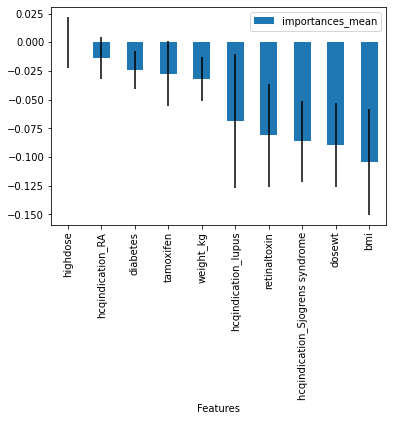

In [29]:
top_predictors_df.plot.bar(yerr='importances_std')
plt.xlabel('Features');